In [23]:
# import os
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# import joblib

# # Method for data preprocessing
# def preprocess_stock_data(ticker):
#     # Reading the data csv
#     df_price = pd.read_csv(f"{ticker}_Daily_Data.csv")
#     df_news = pd.read_csv(f"{ticker}_News_Content.csv")

#     # Convert the 'Date' column to datetime if it's not already
#     df_price['Date'] = pd.to_datetime(df_price['Date'])

#     # Specify the date from which you want to keep the rows
#     start_date = pd.to_datetime('2022-03-01')  # Change this to your desired start date

#     # Filter the DataFrame to keep rows from the start_date onwards
#     df_price = df_price[df_price['Date'] >= start_date]

#     # Reset the index of the filtered DataFrame
#     df_price.reset_index(drop=True, inplace=True)

#     # Extract date components
#     df_news['Date'] = pd.to_datetime(df_news['time_published'], format='%Y%m%dT%H%M%S').dt.date

#     # Convert date to datetime format
#     df_news['Date'] = pd.to_datetime(df_news['Date'])

#     # Define a custom function to determine if a given date is a weekend
#     def is_weekend(date):
#         return date.weekday() >= 5  # 5 and 6 represent Saturday and Sunday

#     # Create a new column 'Date_adjusted' that shifts weekend dates to the next Monday
#     df_news['Date'] = df_news['Date'].apply(lambda x: x + pd.DateOffset(days=2) if is_weekend(x) else x)

#     # Drop unnecessary columns
#     columns_to_drop = ['ticker', 'time_published', 'overall_sentiment_label', 'ticker_sentiment_label']
#     df_news.drop(columns=columns_to_drop, inplace=True)

#     # Group by 'Date_adjusted' and concatenate titles and summaries into a single paragraph
#     agg_functions = {
#         'title': ' '.join,  # Concatenate titles
#         'summary': ' '.join,  # Concatenate summaries
#         'overall_sentiment_score': 'mean',  # Calculate the mean
#         'relevance_score': 'mean',  # Calculate the mean
#         'ticker_sentiment_score': 'mean'  # Calculate the mean
#     }

#     df_news = df_news.groupby('Date').agg(agg_functions).reset_index()

#     # Rename columns if needed
#     df_news.rename(columns={'overall_sentiment_score': 'average_overall_sentiment_score',
#                             'relevance_score': 'average_relevance_score',
#                             'ticker_sentiment_score': 'average_ticker_sentiment_score'},
#                    inplace=True)

#     # Define a custom function to apply the condition
#     def calculate_sentiment(score):
#         if score > 0.5:
#             return 1
#         else:
#             return 0

#     # Apply the custom function to create the 'sentiment score' column
#     df_news['sentiment_score'] = df_news['average_overall_sentiment_score'].apply(calculate_sentiment)

#     # Convert 'Date' column to datetime type in both dataframes
#     df_news['Date'] = pd.to_datetime(df_news['Date'])
#     df_price['Date'] = pd.to_datetime(df_price['Date'])

#     # Perform a left outer join based on the 'Date' column
#     merged_df = pd.merge(df_price, df_news, on='Date', how='left')

#     # Fill NaN values with 0
#     merged_df.fillna(0, inplace=True)

#     # Drop duplicate rows
#     merged_df.drop_duplicates(inplace=True)

#     # Reset the index
#     merged_df.reset_index(drop=True, inplace=True)

#     return merged_df

# # Method to create a dataset for LSTM
# def create_dataset(dataset, time_step=1):
#     x = []
#     y = []
#     for i in range(len(dataset) - time_step - 1):
#         a = dataset[i:(i + time_step), :]
#         x.append(a)
#         y.append(dataset[i + time_step, 0])  # Assuming the 'Close' price is in the first column
#     x = np.array(x)
#     y = np.array(y)
#     return x, y

# # Method to train the LSTM model
# def train_lstm_model(x_train, y_train, time_step, close_scaler, volume_scaler, sentiment_scaler, ticker_symbol):
#     model = Sequential()
#     model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, 3)))  # 3 features: Close, Volume, Sentiment
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=300, return_sequences=True))
#     model.add(Dropout(0.4))
#     model.add(LSTM(units=500, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=100))
#     model.add(Dropout(0.4))
#     model.add(Dense(units=1))  # Output layer for predicting Close prices
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     # Train the model
#     model.fit(x_train, y_train, epochs=150, batch_size=64, verbose=1)

#     # Save the trained model and scalers in a folder
#     model_dir = "trained_lstm_models"
#     os.makedirs(model_dir, exist_ok=True)
#     joblib.dump(close_scaler, os.path.join(model_dir, f"{ticker_symbol}_close_scaler.joblib"))
#     joblib.dump(volume_scaler, os.path.join(model_dir, f"{ticker_symbol}_volume_scaler.joblib"))
#     joblib.dump(sentiment_scaler, os.path.join(model_dir, f"{ticker_symbol}_sentiment_scaler.joblib"))
#     model.save(os.path.join(model_dir, f"{ticker_symbol}_stock_prediction_with_volume_sentiment.keras"))

# if __name__ == "__main__":
#     stock_symbols = ['AAPL']  # Add more stock symbols as needed

#     for tk in stock_symbols:
#         processed_df = preprocess_stock_data(tk)

#         time_step = 100
#         df_features = processed_df[['Close', 'Volume', 'average_overall_sentiment_score']].values
#         x_train, y_train = create_dataset(df_features, time_step)
#         x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 3))  # 3 features: Close, Volume, Sentiment

#         # Initialize MinMaxScalers for each feature
#         close_scaler = MinMaxScaler(feature_range=(0, 1))
#         volume_scaler = MinMaxScaler(feature_range=(0, 1))
#         sentiment_scaler = MinMaxScaler(feature_range=(0, 1))

#         # Fit the scalers to the training data
#         close_scaler.fit(x_train[:, :, 0])
#         volume_scaler.fit(x_train[:, :, 1])
#         sentiment_scaler.fit(x_train[:, :, 2])

#         # Transform the data using the scalers
#         x_train[:, :, 0] = close_scaler.transform(x_train[:, :, 0])
#         x_train[:, :, 1] = volume_scaler.transform(x_train[:, :, 1])
#         x_train[:, :, 2] = sentiment_scaler.transform(x_train[:, :, 2])

#         # Cast NumPy arrays to float32
#         x_train = x_train.astype(np.float32)
#         y_train = y_train.astype(np.float32)

#         train_lstm_model(x_train, y_train, time_step, close_scaler, volume_scaler, sentiment_scaler, tk)

In [24]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import joblib
# from keras.models import load_model
# import matplotlib.pyplot as plt

# def make_stock_predictions(stock_symbol, num_days):
#     # Load the trained models and scalers from the folder
#     close_scaler = joblib.load(f"trained_lstm_models/{stock_symbol}_close_scaler.joblib")
#     volume_scaler = joblib.load(f"trained_lstm_models/{stock_symbol}_volume_scaler.joblib")
#     sentiment_scaler = joblib.load(f"trained_lstm_models/{stock_symbol}_sentiment_scaler.joblib")
#     model = load_model(f"trained_lstm_models/{stock_symbol}_stock_prediction_with_volume_sentiment.keras")

#     # Load historical data from Yahoo Finance
#     ticker = yf.Ticker(stock_symbol)
#     df = ticker.history(interval='1d', start='2022-03-01')
#     df_original = df.copy()

#     def make_future_predictions(model, close_scaler, volume_scaler, sentiment_scaler, df, time_step, num_days):
#         # Create a copy of the original dataframe
#         df_copy = df.copy()

#         # Initialize an empty array to store future predictions
#         future_predictions = []
#         future_dates = []  # To store corresponding dates

#         # Loop to make predictions for the specified number of days
#         for _ in range(num_days):
#             # Prepare the data for the current window
#             df_window = df_copy.iloc[-time_step:]
#             df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
#             df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
#             df_window['Sentiment'] = sentiment_scaler.transform(df_window['Sentiment'].values.reshape(-1, 1))
#             x_window = df_window[['Close', 'Volume', 'Sentiment']].values.reshape(1, -1, 3)  # 3 features

#             # Make a prediction for the next day
#             prediction = model.predict(x_window)
#             prediction = close_scaler.inverse_transform(prediction.reshape(-1, 1))

#             # Append the prediction to the future_predictions array
#             future_predictions.append(prediction[0][0])

#             # Get the date of the next day
#             next_day_date = df_copy.index[-1] + pd.DateOffset(1)
#             future_dates.append(next_day_date)

#             # Update the dataframe for the next iteration
#             new_data_point = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Close']
#             new_volume = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Volume']
#             new_sentiment = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Sentiment']
#             new_data = pd.DataFrame({'Close': [new_data_point], 'Volume': [new_volume], 'Sentiment': [new_sentiment]}, index=[next_day_date])
#             df_copy = pd.concat([df_copy, new_data])

#         return future_dates, future_predictions

#     # Specify the number of time steps (you can adjust this)
#     time_step = 100

#     # Make future predictions
#     future_dates, future_predictions = make_future_predictions(model, close_scaler, volume_scaler, sentiment_scaler, df, time_step, num_days)

#     # Print the future predictions with dates
#     for date, prediction in zip(future_dates, future_predictions):
#         print(f"Date: {date.strftime('%Y-%m-%d')}, Predicted Price: {prediction:.2f}")

#     # Plot the future predictions
#     plt.figure(figsize=(12, 6))
#     plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='b', label='Predicted Price')
#     plt.xlabel('Date')
#     plt.ylabel('Stock Price')
#     plt.title('Future Stock Price Predictions')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# if __name__ == "__main__":
#     stock_symbol = input("Enter the stock symbol (e.g., AAPL): ")  # User input for stock symbol
#     num_days = int(input("Enter the number of days for predictions: "))  # User input for the number of days

#     make_stock_predictions(stock_symbol, num_days)


# !!!!!!!!!!!! Model with Close price and Volumes

In [43]:
import pandas as pd
import numpy as np
import os  # Added import for working with directories
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib

# Method for data preprocessing
def preprocess_stock_data(ticker):
    # Reading the data csv
    df_price = pd.read_csv(f"{ticker}_Daily_Data.csv")
    df_news = pd.read_csv(f"{ticker}_News_Content.csv")

    # Convert the 'Date' column to datetime if it's not already
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Specify the date from which you want to keep the rows
    start_date = pd.to_datetime('2022-03-01')  # Change this to your desired start date

    # Filter the DataFrame to keep rows from the start_date onwards
    df_price = df_price[df_price['Date'] >= start_date]

    # Reset the index of the filtered DataFrame
    df_price.reset_index(drop=True, inplace=True)

    # Extract date components
    df_news['Date'] = pd.to_datetime(df_news['time_published'], format='%Y%m%dT%H%M%S').dt.date

    # Convert date to datetime format
    df_news['Date'] = pd.to_datetime(df_news['Date'])

    # Define a custom function to determine if a given date is a weekend
    def is_weekend(date):
        return date.weekday() >= 5  # 5 and 6 represent Saturday and Sunday

    # Create a new column 'Date_adjusted' that shifts weekend dates to the next Monday
    df_news['Date'] = df_news['Date'].apply(lambda x: x + pd.DateOffset(days=2) if is_weekend(x) else x)

    # Drop unnecessary columns
    columns_to_drop = ['ticker', 'time_published', 'overall_sentiment_label', 'ticker_sentiment_label']
    df_news.drop(columns=columns_to_drop, inplace=True)

    # Group by 'Date_adjusted' and concatenate titles and summaries into a single paragraph
    agg_functions = {
        'title': ' '.join,  # Concatenate titles
        'summary': ' '.join,  # Concatenate summaries
        'overall_sentiment_score': 'mean',  # Calculate the mean
        'relevance_score': 'mean',  # Calculate the mean
        'ticker_sentiment_score': 'mean'  # Calculate the mean
    }

    df_news = df_news.groupby('Date').agg(agg_functions).reset_index()

    # Rename columns if needed
    df_news.rename(columns={'overall_sentiment_score': 'average_overall_sentiment_score',
                            'relevance_score': 'average_relevance_score',
                            'ticker_sentiment_score': 'average_ticker_sentiment_score'},
                   inplace=True)

    # Define a custom function to apply the condition
    def calculate_sentiment(score):
        if score > 0:
            return int(1)
        else:
            return int(0)

    # Apply the custom function to create the 'sentiment score' column
    df_news['sentiment_score'] = df_news['average_overall_sentiment_score'].apply(calculate_sentiment)

    # Convert 'Date' column to datetime type in both dataframes
    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Perform a left outer join based on the 'Date' column
    merged_df = pd.merge(df_price, df_news, on='Date', how='left')

    # Fill NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Drop duplicate rows
    merged_df.drop_duplicates(inplace=True)

    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)

    # Convert 'sentiment_score' column to integer
    merged_df['sentiment_score'] = merged_df['sentiment_score'].astype(int)

    return merged_df

# Method to train the LSTM model
def train_lstm_model(df, stock_symbol, time_step=100, batch_size=64, epochs=150):
    # Initialize MinMaxScaler for closing prices
    close_scaler = MinMaxScaler(feature_range=(0, 1))

    # Initialize MinMaxScaler for trading volumes
    volume_scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the closing prices and volumes separately
    df['Close'] = close_scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    df['Volume'] = volume_scaler.fit_transform(df['Volume'].values.reshape(-1, 1))

    def create_dataset(dataset, time_step=1):
        x = []
        y = []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), :]
            x.append(a)
            y.append(dataset[i + time_step, 0])  # Assuming the 'Close' price is in the first column
        x = np.array(x)
        y = np.array(y)
        return x, y

    # Create the Stacked LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, 2)))  # 2 features: Close and Volume
    model.add(Dropout(0.2))
    model.add(LSTM(units=300, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=500, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))  # Output layer for predicting Close prices
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Data preparation
    df_features = df[['Close', 'Volume']].values
    x_train, y_train = create_dataset(df_features, time_step)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))  # 2 features

    # Train the model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Create a directory to save the models if it doesn't exist
    save_dir = 'trained_lstm_models'
    os.makedirs(save_dir, exist_ok=True)

    # Save the trained model and scalers in the directory
    joblib.dump(close_scaler, os.path.join(save_dir, stock_symbol + '_close_scaler.joblib'))
    joblib.dump(volume_scaler, os.path.join(save_dir, stock_symbol + '_volume_scaler.joblib'))
    model.save(os.path.join(save_dir, stock_symbol + '_stock_prediction_with_volume.keras'))

if __name__ == "__main__":
    stock_symbols = ['AAPL']  # Add more stock symbols as needed
    for tk in stock_symbols:
        processed_df = preprocess_stock_data(tk)
        train_lstm_model(processed_df, tk)


Epoch 1/150
5/5 [==============================] - 21s 3s/step - loss: 0.1335
Epoch 2/150
5/5 [==============================] - 16s 3s/step - loss: 0.0971
Epoch 3/150
5/5 [==============================] - 17s 3s/step - loss: 0.0355
Epoch 4/150
5/5 [==============================] - 16s 3s/step - loss: 0.0271
Epoch 5/150
5/5 [==============================] - 16s 3s/step - loss: 0.0186
Epoch 6/150
5/5 [==============================] - 16s 3s/step - loss: 0.0161
Epoch 7/150
5/5 [==============================] - 16s 3s/step - loss: 0.0146
Epoch 8/150
5/5 [==============================] - 16s 3s/step - loss: 0.0141
Epoch 9/150
5/5 [==============================] - 16s 3s/step - loss: 0.0118
Epoch 10/150
5/5 [==============================] - 17s 3s/step - loss: 0.0104
Epoch 11/150
5/5 [==============================] - 16s 3s/step - loss: 0.0118
Epoch 12/150
5/5 [==============================] - 16s 3s/step - loss: 0.0107
Epoch 13/150
5/5 [==============================] - 17s 3s/st

5/5 [==============================] - 17s 3s/step - loss: 0.0062
Epoch 105/150
5/5 [==============================] - 17s 3s/step - loss: 0.0056
Epoch 106/150
5/5 [==============================] - 17s 3s/step - loss: 0.0060
Epoch 107/150
5/5 [==============================] - 17s 3s/step - loss: 0.0052
Epoch 108/150
5/5 [==============================] - 17s 3s/step - loss: 0.0063
Epoch 109/150
5/5 [==============================] - 17s 3s/step - loss: 0.0055
Epoch 110/150
5/5 [==============================] - 17s 3s/step - loss: 0.0073
Epoch 111/150
5/5 [==============================] - 17s 3s/step - loss: 0.0071
Epoch 112/150
5/5 [==============================] - 17s 3s/step - loss: 0.0069
Epoch 113/150
5/5 [==============================] - 16s 3s/step - loss: 0.0061
Epoch 114/150
5/5 [==============================] - 17s 3s/step - loss: 0.0060
Epoch 115/150
5/5 [==============================] - 16s 3s/step - loss: 0.0068
Epoch 116/150
5/5 [==============================] - 1

In [59]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import joblib
import os

# Method for data preprocessing
def preprocess_stock_data(ticker):
    # Reading the data csv
    df_price = pd.read_csv(f"{ticker}_Daily_Data.csv")
    df_news = pd.read_csv(f"{ticker}_News_Content.csv")

    # Convert the 'Date' column to datetime if it's not already
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Specify the date from which you want to keep the rows
    start_date = pd.to_datetime('2022-03-01')  # Change this to your desired start date

    # Filter the DataFrame to keep rows from the start_date onwards
    df_price = df_price[df_price['Date'] >= start_date]

    # Reset the index of the filtered DataFrame
    df_price.reset_index(drop=True, inplace=True)

    # Extract date components
    df_news['Date'] = pd.to_datetime(df_news['time_published'], format='%Y%m%dT%H%M%S').dt.date

    # Convert date to datetime format
    df_news['Date'] = pd.to_datetime(df_news['Date'])

    # Define a custom function to determine if a given date is a weekend
    def is_weekend(date):
        return date.weekday() >= 5  # 5 and 6 represent Saturday and Sunday

    # Create a new column 'Date_adjusted' that shifts weekend dates to the next Monday
    df_news['Date'] = df_news['Date'].apply(lambda x: x + pd.DateOffset(days=2) if is_weekend(x) else x)

    # Drop unnecessary columns
    columns_to_drop = ['ticker', 'time_published', 'overall_sentiment_label', 'ticker_sentiment_label']
    df_news.drop(columns=columns_to_drop, inplace=True)

    # Group by 'Date_adjusted' and concatenate titles and summaries into a single paragraph
    agg_functions = {
        'title': ' '.join,  # Concatenate titles
        'summary': ' '.join,  # Concatenate summaries
        'overall_sentiment_score': 'mean',  # Calculate the mean
        'relevance_score': 'mean',  # Calculate the mean
        'ticker_sentiment_score': 'mean'  # Calculate the mean
    }

    df_news = df_news.groupby('Date').agg(agg_functions).reset_index()

    # Rename columns if needed
    df_news.rename(columns={'overall_sentiment_score': 'average_overall_sentiment_score',
                            'relevance_score': 'average_relevance_score',
                            'ticker_sentiment_score': 'average_ticker_sentiment_score'},
                   inplace=True)

    # Define a custom function to apply the condition
    def calculate_sentiment(score):
        if score > 0:
            return int(1)
        else:
            return int(0)

    # Apply the custom function to create the 'sentiment score' column
    df_news['sentiment_score'] = df_news['average_overall_sentiment_score'].apply(calculate_sentiment)

    # Convert 'Date' column to datetime type in both dataframes
    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Perform a left outer join based on the 'Date' column
    merged_df = pd.merge(df_price, df_news, on='Date', how='left')

    # Fill NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Drop duplicate rows
    merged_df.drop_duplicates(inplace=True)

    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)

    # Convert 'sentiment_score' column to integer
    merged_df['sentiment_score'] = merged_df['sentiment_score'].astype(int)

    # Set 'Date' column as the index
    merged_df.set_index('Date', inplace=True)

    return merged_df

Enter the stock symbol (e.g., MSFT): AAPL
Enter the number of days for future predictions: 10


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))


1/1 [==============================] - 0s 61ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is

1/1 [==============================] - 0s 65ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is

1/1 [==============================] - 0s 65ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is

1/1 [==============================] - 0s 63ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is

1/1 [==============================] - 0s 66ms/step
Date: 2023-09-30, Predicted Price: 171.88
Date: 2023-10-01, Predicted Price: 171.94
Date: 2023-10-02, Predicted Price: 173.01
Date: 2023-10-03, Predicted Price: 174.20
Date: 2023-10-04, Predicted Price: 174.63
Date: 2023-10-05, Predicted Price: 176.60
Date: 2023-10-06, Predicted Price: 181.64
Date: 2023-10-07, Predicted Price: 188.35
Date: 2023-10-08, Predicted Price: 191.51
Date: 2023-10-09, Predicted Price: 188.10


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\440531681.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))


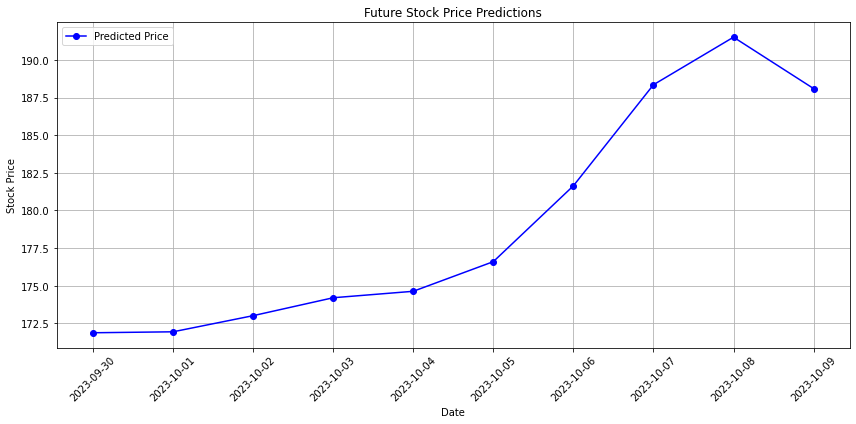

In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import joblib
import os

# Get user inputs for the stock symbol and number of days to predict
tk = input("Enter the stock symbol (e.g., MSFT): ")
num_days_future = int(input("Enter the number of days for future predictions: "))

# Define the directory where the trained models are stored
model_dir = 'trained_lstm_models'

# Load MinMaxScalers for closing prices and trading volumes
close_scaler = joblib.load(os.path.join(model_dir, tk + '_close_scaler.joblib'))
volume_scaler = joblib.load(os.path.join(model_dir, tk + '_volume_scaler.joblib'))

# Load the pre-trained model
model = load_model(os.path.join(model_dir, tk + '_stock_prediction_with_volume.keras'))

# # Load historical data for the specified stock symbol
df = preprocess_stock_data(tk)
df_original = df.copy()

time_step = 100

# Set a fixed seed for random number generation
np.random.seed(0)

def make_future_predictions(model, close_scaler, volume_scaler, df, time_step, num_days):
    # Create a copy of the original dataframe
    df_copy = df.copy()

    # Initialize an empty array to store future predictions
    future_predictions = []
    future_dates = []  # To store corresponding dates

    # Loop to make predictions for the specified number of days
    for _ in range(num_days):
        # Prepare the data for the current window
        df_window = df_copy.iloc[-time_step:]
        df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
        df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
        x_window = df_window[['Close', 'Volume']].values.reshape(1, -1, 2)  # 2 features

        # Make a prediction for the next day
        prediction = model.predict(x_window)
        prediction = close_scaler.inverse_transform(prediction)

        # Append the prediction to the future_predictions array
        future_predictions.append(prediction[0][0])

        # Get the date of the next day
        next_day_date = df_copy.index[-1] + pd.DateOffset(1)
        future_dates.append(next_day_date)

        # Update the dataframe for the next iteration
        new_data_point = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Close']
        new_volume = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Volume']
        new_data = pd.DataFrame({'Close': [new_data_point], 'Volume': [new_volume]}, index=[next_day_date])
        df_copy = pd.concat([df_copy, new_data])

    return future_dates, future_predictions

# Make future predictions
future_dates, future_predictions = make_future_predictions(model, close_scaler, volume_scaler, df, time_step, num_days_future)

# Print the future predictions with dates
for date, prediction in zip(future_dates, future_predictions):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Predicted Price: {prediction:.2f}")

# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='b', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Future Stock Price Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# !!!!!!!!!!!! Model with Close price, Volumes and Sentiment Scores

In [60]:
import pandas as pd
import numpy as np
import os  # Added import for working with directories
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib

# Method for data preprocessing
def preprocess_stock_data(ticker):
    # Reading the data csv
    df_price = pd.read_csv(f"{ticker}_Daily_Data.csv")
    df_news = pd.read_csv(f"{ticker}_News_Content.csv")

    # Convert the 'Date' column to datetime if it's not already
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Specify the date from which you want to keep the rows
    start_date = pd.to_datetime('2022-03-01')  # Change this to your desired start date

    # Filter the DataFrame to keep rows from the start_date onwards
    df_price = df_price[df_price['Date'] >= start_date]

    # Reset the index of the filtered DataFrame
    df_price.reset_index(drop=True, inplace=True)

    # Extract date components
    df_news['Date'] = pd.to_datetime(df_news['time_published'], format='%Y%m%dT%H%M%S').dt.date

    # Convert date to datetime format
    df_news['Date'] = pd.to_datetime(df_news['Date'])

    # Define a custom function to determine if a given date is a weekend
    def is_weekend(date):
        return date.weekday() >= 5  # 5 and 6 represent Saturday and Sunday

    # Create a new column 'Date_adjusted' that shifts weekend dates to the next Monday
    df_news['Date'] = df_news['Date'].apply(lambda x: x + pd.DateOffset(days=2) if is_weekend(x) else x)

    # Drop unnecessary columns
    columns_to_drop = ['ticker', 'time_published', 'overall_sentiment_label', 'ticker_sentiment_label']
    df_news.drop(columns=columns_to_drop, inplace=True)

    # Group by 'Date_adjusted' and concatenate titles and summaries into a single paragraph
    agg_functions = {
        'title': ' '.join,  # Concatenate titles
        'summary': ' '.join,  # Concatenate summaries
        'overall_sentiment_score': 'mean',  # Calculate the mean
        'relevance_score': 'mean',  # Calculate the mean
        'ticker_sentiment_score': 'mean'  # Calculate the mean
    }

    df_news = df_news.groupby('Date').agg(agg_functions).reset_index()

    # Rename columns if needed
    df_news.rename(columns={'overall_sentiment_score': 'average_overall_sentiment_score',
                            'relevance_score': 'average_relevance_score',
                            'ticker_sentiment_score': 'average_ticker_sentiment_score'},
                   inplace=True)

    # Define a custom function to apply the condition
    def calculate_sentiment(score):
        if score > 0:
            return int(1)
        else:
            return int(0)

    # Apply the custom function to create the 'sentiment score' column
    df_news['sentiment_score'] = df_news['average_overall_sentiment_score'].apply(calculate_sentiment)

    # Convert 'Date' column to datetime type in both dataframes
    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Perform a left outer join based on the 'Date' column
    merged_df = pd.merge(df_price, df_news, on='Date', how='left')

    # Fill NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Drop duplicate rows
    merged_df.drop_duplicates(inplace=True)

    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)

    # Convert 'sentiment_score' column to integer
    merged_df['sentiment_score'] = merged_df['sentiment_score'].astype(int)

    return merged_df

# Method to train the LSTM model
def train_lstm_model(df, stock_symbol, time_step=100, batch_size=64, epochs=150):
    # Initialize MinMaxScaler for closing prices
    close_scaler = MinMaxScaler(feature_range=(0, 1))

    # Initialize MinMaxScaler for trading volumes
    volume_scaler = MinMaxScaler(feature_range=(0, 1))

    # Initialize MinMaxScaler for sentiment scores
    sentiment_scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the closing prices, volumes, and sentiment scores separately
    df['Close'] = close_scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    df['Volume'] = volume_scaler.fit_transform(df['Volume'].values.reshape(-1, 1))
    df['sentiment_score'] = sentiment_scaler.fit_transform(df['sentiment_score'].values.reshape(-1, 1))

    def create_dataset(dataset, time_step=1):
        x = []
        y = []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), :]
            x.append(a)
            y.append(dataset[i + time_step, 0])  # Assuming the 'Close' price is in the first column
        x = np.array(x)
        y = np.array(y)
        return x, y

    # Create the Stacked LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, 3)))  # 3 features: Close, Volume, sentiment_score
    model.add(Dropout(0.2))
    model.add(LSTM(units=300, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=500, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))  # Output layer for predicting Close prices
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Data preparation
    df_features = df[['Close', 'Volume', 'sentiment_score']].values
    x_train, y_train = create_dataset(df_features, time_step)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 3))  # 3 features

    # Train the model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Create a directory to save the models if it doesn't exist
    save_dir = 'trained_lstm_models_with_sentiment'
    os.makedirs(save_dir, exist_ok=True)

    # Save the trained model and scalers in the directory
    joblib.dump(close_scaler, os.path.join(save_dir, stock_symbol + '_close_scaler.joblib'))
    joblib.dump(volume_scaler, os.path.join(save_dir, stock_symbol + '_volume_scaler.joblib'))
    joblib.dump(sentiment_scaler, os.path.join(save_dir, stock_symbol + '_sentiment_scaler.joblib'))
    model.save(os.path.join(save_dir, stock_symbol + '_stock_prediction_with_volume_sentiment.keras'))

if __name__ == "__main__":
    stock_symbols = ['AAPL']  # Add more stock symbols as needed
    for tk in stock_symbols:
        processed_df = preprocess_stock_data(tk)
        train_lstm_model(processed_df, tk)


Epoch 1/150
5/5 [==============================] - 23s 4s/step - loss: 0.1168
Epoch 2/150
5/5 [==============================] - 18s 4s/step - loss: 0.0226
Epoch 3/150
5/5 [==============================] - 21s 4s/step - loss: 0.0172
Epoch 4/150
5/5 [==============================] - 32s 7s/step - loss: 0.0136
Epoch 5/150
5/5 [==============================] - 25s 5s/step - loss: 0.0142
Epoch 6/150
5/5 [==============================] - 20s 4s/step - loss: 0.0162
Epoch 7/150
5/5 [==============================] - 19s 4s/step - loss: 0.0126
Epoch 8/150
5/5 [==============================] - 20s 4s/step - loss: 0.0115
Epoch 9/150
5/5 [==============================] - 20s 4s/step - loss: 0.0126
Epoch 10/150
5/5 [==============================] - 19s 4s/step - loss: 0.0131
Epoch 11/150
5/5 [==============================] - 18s 4s/step - loss: 0.0095
Epoch 12/150
5/5 [==============================] - 18s 4s/step - loss: 0.0145
Epoch 13/150
5/5 [==============================] - 18s 4s/st

5/5 [==============================] - 18s 4s/step - loss: 0.0064
Epoch 105/150
5/5 [==============================] - 18s 4s/step - loss: 0.0053
Epoch 106/150
5/5 [==============================] - 18s 4s/step - loss: 0.0046
Epoch 107/150
5/5 [==============================] - 18s 4s/step - loss: 0.0055
Epoch 108/150
5/5 [==============================] - 18s 4s/step - loss: 0.0062
Epoch 109/150
5/5 [==============================] - 18s 4s/step - loss: 0.0052
Epoch 110/150
5/5 [==============================] - 18s 4s/step - loss: 0.0054
Epoch 111/150
5/5 [==============================] - 18s 4s/step - loss: 0.0050
Epoch 112/150
5/5 [==============================] - 18s 4s/step - loss: 0.0054
Epoch 113/150
5/5 [==============================] - 18s 4s/step - loss: 0.0051
Epoch 114/150
5/5 [==============================] - 18s 4s/step - loss: 0.0050
Epoch 115/150
5/5 [==============================] - 18s 4s/step - loss: 0.0052
Epoch 116/150
5/5 [==============================] - 1

In [63]:
def preprocess_stock_data(ticker):
    # Reading the data csv
    df_price = pd.read_csv(f"{ticker}_Daily_Data.csv")
    df_news = pd.read_csv(f"{ticker}_News_Content.csv")

    # Convert the 'Date' column to datetime if it's not already
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Specify the date from which you want to keep the rows
    start_date = pd.to_datetime('2022-03-01')  # Change this to your desired start date

    # Filter the DataFrame to keep rows from the start_date onwards
    df_price = df_price[df_price['Date'] >= start_date]

    # Reset the index of the filtered DataFrame
    df_price.reset_index(drop=True, inplace=True)

    # Extract date components
    df_news['Date'] = pd.to_datetime(df_news['time_published'], format='%Y%m%dT%H%M%S').dt.date

    # Convert date to datetime format
    df_news['Date'] = pd.to_datetime(df_news['Date'])

    # Define a custom function to determine if a given date is a weekend
    def is_weekend(date):
        return date.weekday() >= 5  # 5 and 6 represent Saturday and Sunday

    # Create a new column 'Date_adjusted' that shifts weekend dates to the next Monday
    df_news['Date'] = df_news['Date'].apply(lambda x: x + pd.DateOffset(days=2) if is_weekend(x) else x)

    # Drop unnecessary columns
    columns_to_drop = ['ticker', 'time_published', 'overall_sentiment_label', 'ticker_sentiment_label']
    df_news.drop(columns=columns_to_drop, inplace=True)

    # Group by 'Date_adjusted' and concatenate titles and summaries into a single paragraph
    agg_functions = {
        'title': ' '.join,  # Concatenate titles
        'summary': ' '.join,  # Concatenate summaries
        'overall_sentiment_score': 'mean',  # Calculate the mean
        'relevance_score': 'mean',  # Calculate the mean
        'ticker_sentiment_score': 'mean'  # Calculate the mean
    }

    df_news = df_news.groupby('Date').agg(agg_functions).reset_index()

    # Rename columns if needed
    df_news.rename(columns={'overall_sentiment_score': 'average_overall_sentiment_score',
                            'relevance_score': 'average_relevance_score',
                            'ticker_sentiment_score': 'average_ticker_sentiment_score'},
                   inplace=True)

    # Define a custom function to apply the condition
    def calculate_sentiment(score):
        if score > 0:
            return int(1)
        else:
            return int(0)

    # Apply the custom function to create the 'sentiment score' column
    df_news['sentiment_score'] = df_news['average_overall_sentiment_score'].apply(calculate_sentiment)

    # Convert 'Date' column to datetime type in both dataframes
    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    # Perform a left outer join based on the 'Date' column
    merged_df = pd.merge(df_price, df_news, on='Date', how='left')

    # Fill NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Drop duplicate rows
    merged_df.drop_duplicates(inplace=True)

    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)

    # Convert 'sentiment_score' column to integer
    merged_df['sentiment_score'] = merged_df['sentiment_score'].astype(int)
    
    # Set 'Date' column as the index
    merged_df.set_index('Date', inplace=True)

    return merged_df

Enter the stock symbol (e.g., MSFT): AAPL
Enter the number of days for future predictions: 10


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))


1/1 [==============================] - 0s 62ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value

1/1 [==============================] - 0s 60ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value

1/1 [==============================] - 0s 67ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value

1/1 [==============================] - 0s 64ms/step


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value

1/1 [==============================] - 0s 76ms/step
Date: 2023-09-30, Predicted Price: 171.52
Date: 2023-10-01, Predicted Price: 169.88
Date: 2023-10-02, Predicted Price: 169.42
Date: 2023-10-03, Predicted Price: 170.37
Date: 2023-10-04, Predicted Price: 171.16
Date: 2023-10-05, Predicted Price: 170.60
Date: 2023-10-06, Predicted Price: 169.10
Date: 2023-10-07, Predicted Price: 167.90
Date: 2023-10-08, Predicted Price: 167.81
Date: 2023-10-09, Predicted Price: 167.09


C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
C:\Users\Shemeen62\AppData\Local\Temp\ipykernel_9372\1970124924.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))


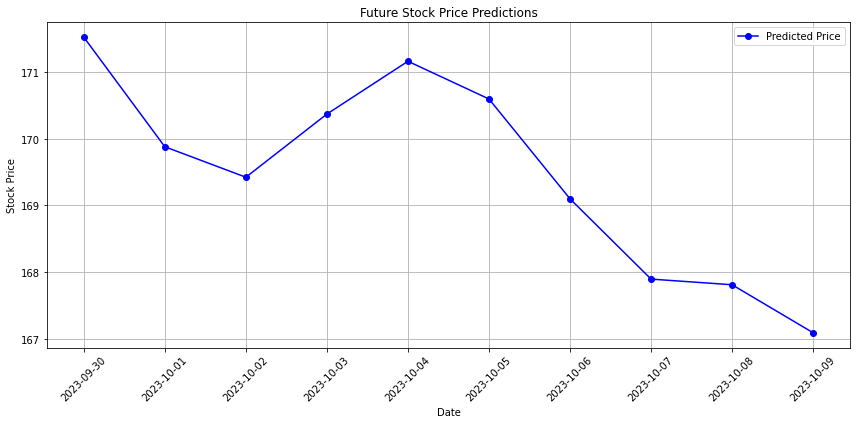

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import joblib
import os

# Get user inputs for the stock symbol and number of days to predict
tk = input("Enter the stock symbol (e.g., MSFT): ")
num_days_future = int(input("Enter the number of days for future predictions: "))

# Define the directory where the trained models are stored
model_dir = 'trained_lstm_models_with_sentiment'

# Load MinMaxScalers for closing prices and trading volumes
close_scaler = joblib.load(os.path.join(model_dir, tk + '_close_scaler.joblib'))
volume_scaler = joblib.load(os.path.join(model_dir, tk + '_volume_scaler.joblib'))

# Load the pre-trained model
model = load_model(os.path.join(model_dir, tk + '_stock_prediction_with_volume_sentiment.keras'))

# # Load historical data for the specified stock symbol
# # Load historical data for the specified stock symbol
df = preprocess_stock_data(tk)
df_original = df.copy()

time_step = 100

# Set a fixed seed for random number generation
np.random.seed(0)

def make_future_predictions(model, close_scaler, volume_scaler, df, time_step, num_days):
    # Create a copy of the original dataframe
    df_copy = df.copy()

    # Initialize an empty array to store future predictions
    future_predictions = []
    future_dates = []  # To store corresponding dates

    # Loop to make predictions for the specified number of days
    for _ in range(num_days):
        # Prepare the data for the current window
        df_window = df_copy.iloc[-time_step:]
        df_window['Close'] = close_scaler.transform(df_window['Close'].values.reshape(-1, 1))
        df_window['Volume'] = volume_scaler.transform(df_window['Volume'].values.reshape(-1, 1))
        x_window = df_window[['Close', 'Volume', 'sentiment_score']].values.reshape(1, -1, 3)  # 3 features

        # Make a prediction for the next day
        prediction = model.predict(x_window)
        prediction = close_scaler.inverse_transform(prediction)

        # Append the prediction to the future_predictions array
        future_predictions.append(prediction[0][0])

        # Get the date of the next day
        next_day_date = df_copy.index[-1] + pd.DateOffset(1)
        future_dates.append(next_day_date)

        # Update the dataframe for the next iteration
        new_data_point = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Close']
        new_volume = np.random.uniform(0.9, 1.1) * df_copy.iloc[-1]['Volume']
        new_sentiment = np.random.uniform(0, 1)  # Random sentiment score for demonstration
        new_data = pd.DataFrame({'Close': [new_data_point], 'Volume': [new_volume], 'sentiment_score': [new_sentiment]}, index=[next_day_date])
        df_copy = pd.concat([df_copy, new_data])

    return future_dates, future_predictions

# Make future predictions
future_dates, future_predictions = make_future_predictions(model, close_scaler, volume_scaler, df, time_step, num_days_future)

# Print the future predictions with dates
for date, prediction in zip(future_dates, future_predictions):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Predicted Price: {prediction:.2f}")

# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='b', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Future Stock Price Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
